# 번호판 인식 프로그램

## 모듈 불러오기

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
#from tensorflow.keras import datasets, layers, models
from tensorflow.keras import datasets, layers, models, Input, Model
from tensorflow.keras.models import load_model

import cropchar # 번호판에서 글자를 잘라주는 모듈. 개별적으로 만듬

import os

## Read Input Image

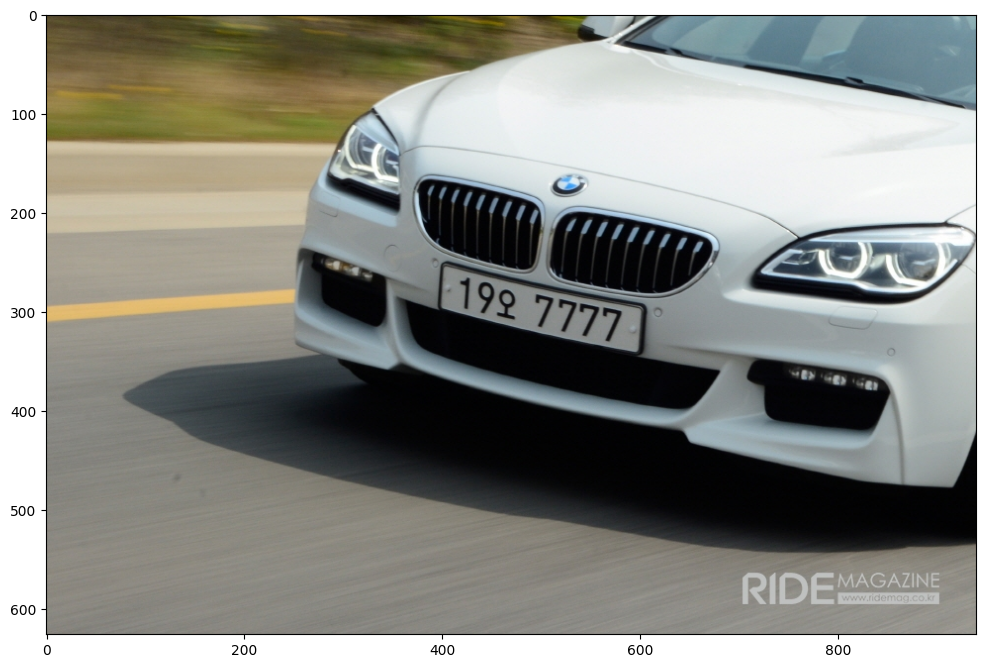

In [2]:
img_ori = cv2.imread('1.jpg')

height, width, channel = img_ori.shape


b, g, r = cv2.split(img_ori) # OpenCV에서 사용하는 이미지 방식이 bgr이므로 rgb방식으로 이미지를 재구성 하기위해 값을 가져옴

rgbImg = cv2.merge([r,g,b]) # 이미지 rgb로 재구성
plt.figure(figsize=(12, 10)) # 인치단위로 창 생성
plt.imshow(rgbImg) # 이미지 matplotlib으로 출력

## Convert Image to Grayscale

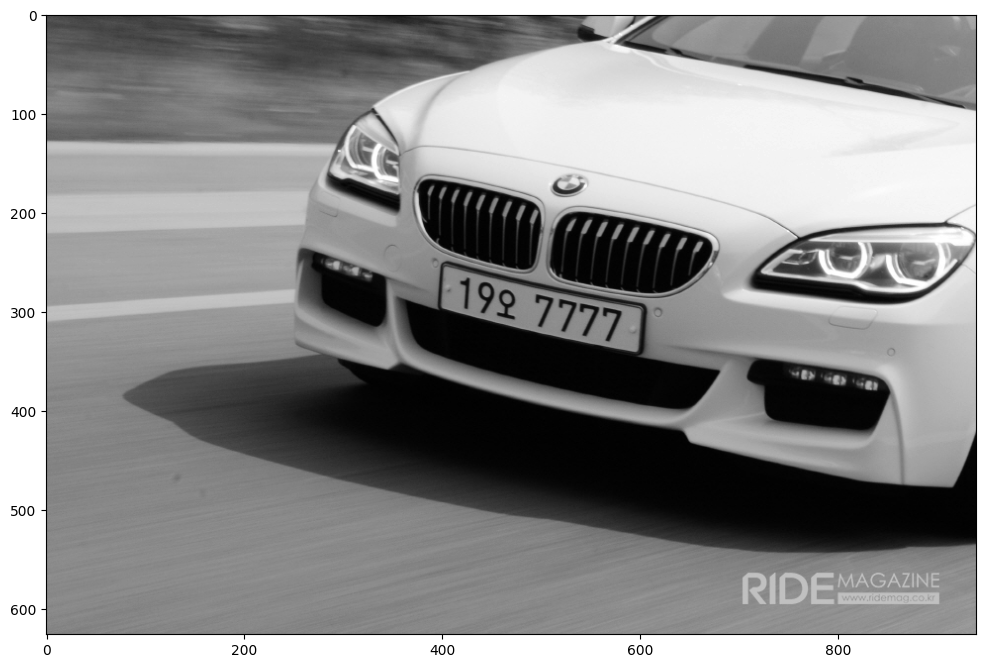

In [3]:
# hsv = cv2.cvtColor(img_ori, cv2.COLOR_BGR2HSV)
# gray = hsv[:,:,2]
gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY) # 흑백으로 변환

plt.figure(figsize=(12, 10)) # 인치단위로 창 생성
plt.imshow(gray, cmap='gray') # 이미지 출력. 흑백이미지므로 cmap 패러미터에 gray전달.

## Maximize Contrast (Optional)

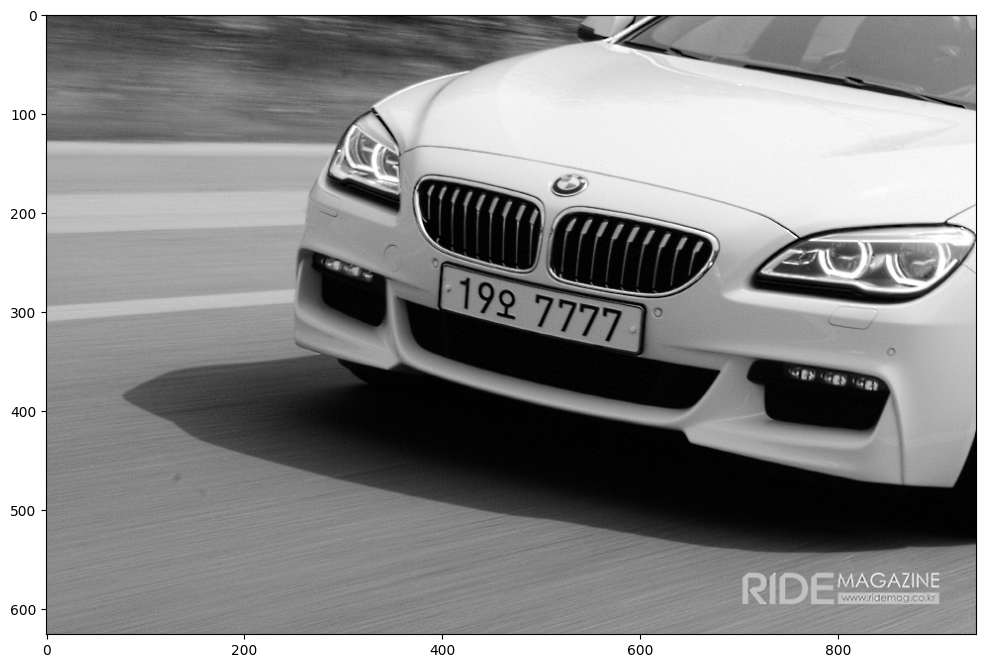

In [4]:
structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)) # 3 * 3 크기의 박스 마스크 생성 (8-방향 확인)
imgTopHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, structuringElement) # 모폴로지 Opening 연산을 적용한 영상과 원본영상의 차이를 구함 (TopHat) --> 영상처리방법론설명자료 folder: white-black tophat.pdf참고
imgBlackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuringElement) # 모폴로지 Closing 연산을 적용한 영상과 원본영상의 차이를 구함 (BlackHat)
imgGrayscalePlusTopHat = cv2.add(gray, imgTopHat) # TopHat을 원본 영상에 더해줌
gray = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat) # BlackHat을 원본 영상에 빼줌

# 최종적으로 영상의 밝은 부분은 더 밝아지고 어두운 부분은 더 어두워지게 된다. Contrast up

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')

## Gaussian Blurring

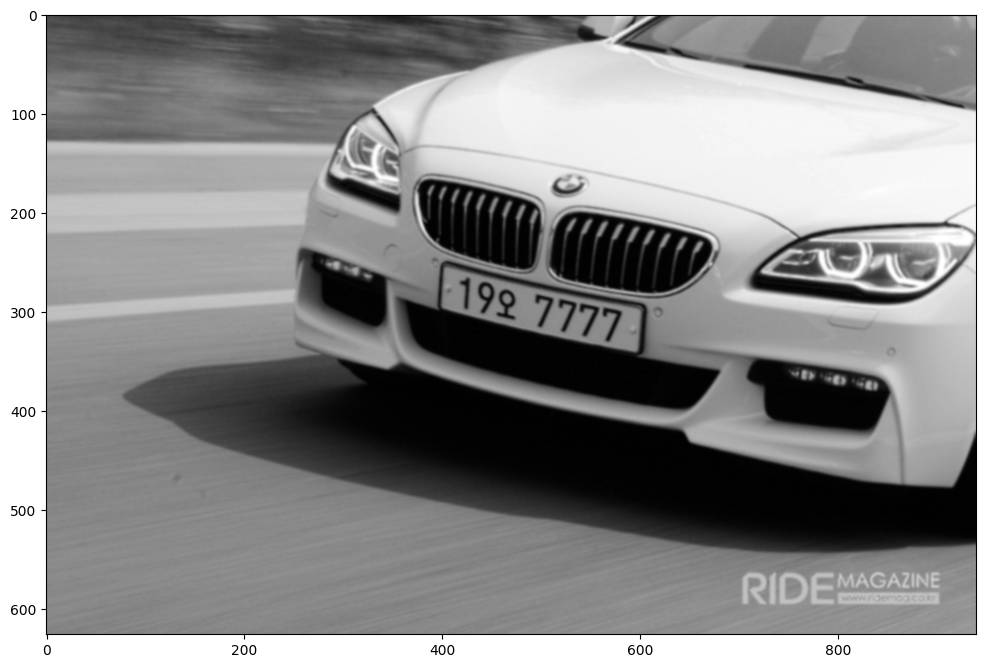

In [5]:
img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0) # 5 * 5 크기의 가우시안 마스크를 영상에 적용.

plt.figure(figsize=(12, 10))
plt.imshow(img_blurred, cmap='gray')

## Adaptive Thresholding

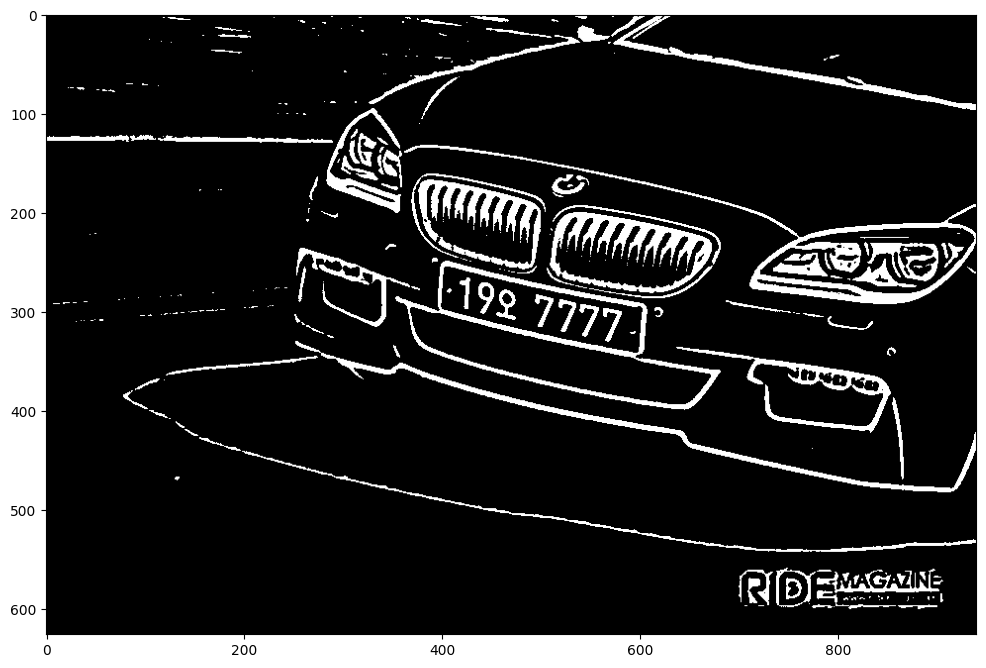

In [6]:
img_thresh = cv2.adaptiveThreshold(
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)

# 이진화 ---> 영상처리방법론설명자료 folder: 2-apdative_threshold foldr 참고
# img, 최대값
'''
adaptive method = T값의 결정 방법. (T를 기준으로 영상의 픽셀값이 255 또는 0으로 이진화 된다.)
cv2.ADAPTIVE_THRESH_GAUSSIAN_C : 가우시안 커널을 만들어서 적용한 후(커널사이즈는 Blocksize^2) 그 결과값을 T로 책정
cv2.ADAPTIVE_THRESH_MEAN_C : blocksize^2만큼의 영역을 만들어서 그 값들의 평균을 T로 책정(메디안 필터)

thresholdType = 픽셀 값 결정 방법.
cv2.THRESH_BINARY_INV : 픽셀값이 T보다 작을경우 값은 255
cv2.THRESH_BINARY : 픽셀값 T보다 클경우 값은 255

blockSize : 커널의 사이즈. adaptive method와 연관있음.
C : adaptive method와 연관있는 값으로 T 연산결과에서 빼주는 상수값임.
'''

# 19x19만큼의 영역 내에서 T를 계산하여 각 픽셀값을 이진화 시킨다.

plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')

## Find Contours

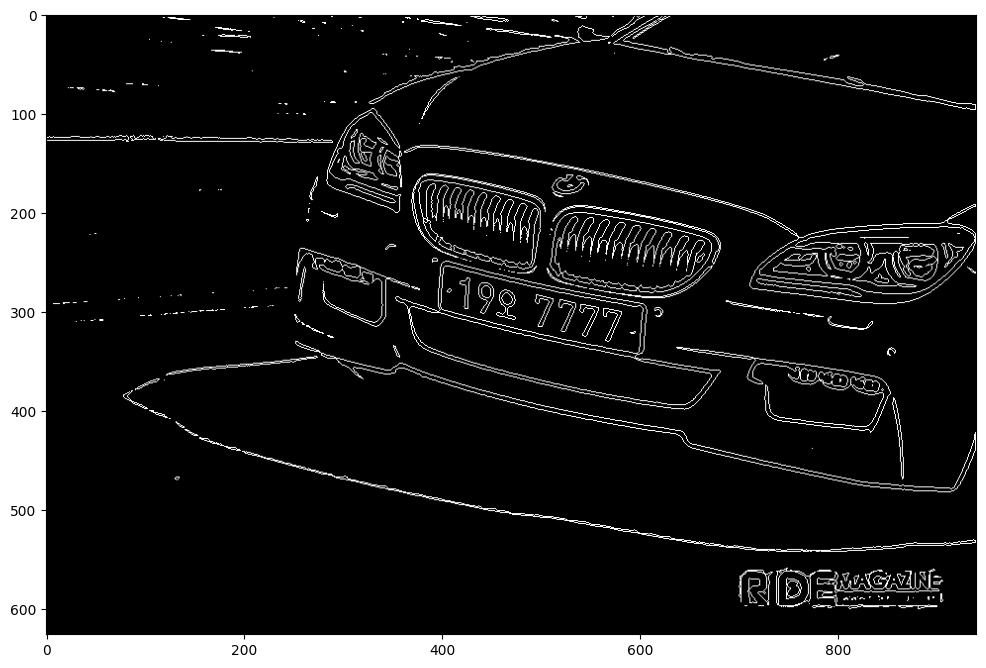

In [7]:
contours, _ = cv2.findContours(
    img_thresh, 
    mode=cv2.RETR_LIST, 
    method=cv2.CHAIN_APPROX_SIMPLE
) # (image, mode, method) # 윤곽선 찾는 함수
'''
Suzuki, S. and Abe, K., Topological Structural Analysis of Digitized Binary Images by Border Following. CVGIP 30 1, pp 32-46 (1985)
위의 논문 내용을 토대로 윤곽선을 찾아냄
https://www.academia.edu/15495158/Topological_Structural_Analysis_of_Digitized_Binary_Images_by_Border_Following

mode : 뽑아낼 윤곽선의 위치
CV_RETR_EXTERNAL : 가장 외곽에 위치한 윤곽선만 추출 (계층 구조 없음)
CV_RETR_LIST : 모든 윤곽선을 추출 (계층 구조 없음)
CV_RETR_CCOMP : 모든 윤곽선 추출 (계층구조 2단계)
CV_RETR_TREE : 모든 윤곽선 추출 (트리형식의 모든 계층구조)

method : 윤곽선 근사화 방법
CV_CHAIN_APPROX_NONE : 모든 윤곽선과 그 윤곽선의 정확한 위치를 기록하여 저장
CV_CHAIN_APPROX_SIMPLE : 윤곽선의 수직 수평 대각선을 압축하여 끝점만을 기록하여 저장  <-----
CV_CHAIN_APPROX_TC89_L1,CV_CHAIN_APPROX_TC89_KCOS : Teh-Chin chain approximation algorithm의 방법을 사용
Teh, C.H. and Chin, R.T., On the Detection of Dominant Points on Digital Curve. PAMI 11 8, pp 859-872 (1989)
https://076923.github.io/posts/Python-opencv-21/ <-참조
'''
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255)) # 윤곽선을 그린다.
'''
img, 윤곽선 벡터, 그릴윤곽선의 인덱스(음수일경우 모두 그림), 윤곽선의 색
'''

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)

## Prepare Data

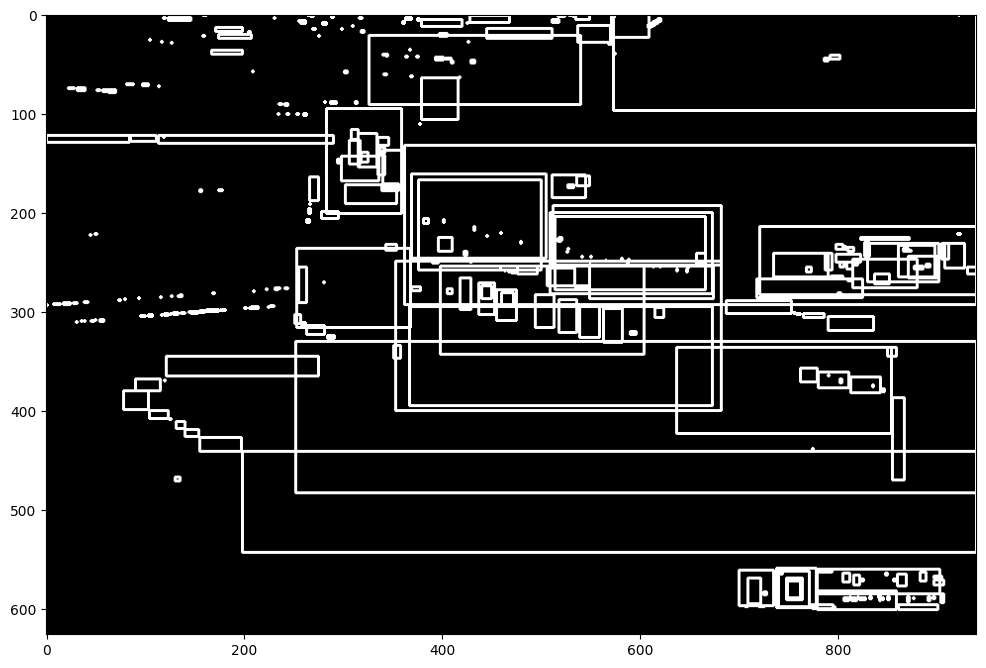

In [8]:
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = [] # 각 윤곽선에서 사각형 영역과 중심좌표를 알아내어 저장할 리스트

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour) # 끝점에서 사각형 영역을 뽑아낸다
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2) # 윤곽선을 사각형으로 그려서 표현
    
    # dictionary를 만든 후 리스트에 추가 - [etc참고\python보충-Dictionary] folder 참고
    contours_dict.append({
        'contour': contour, # 실제 윤곽선
        'x': x,             # 윤곽선의 왼쪽 상단 x좌표
        'y': y,             # 윤곽선의 왼쪽 상단 y좌표
        'w': w,             # 윤곽선의 너비
        'h': h,             # 윤곽선의 높이
        'cx': x + (w / 2),  # 윤곽선의 중심 x좌표 - 전체 영상 내에서의 절대죄표
        'cy': y + (h / 2)   # 윤곽선의 중심 y좌표
    }) 

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray') # 뽑아낸 영역들 출력.

## Select Candidates by Char Size

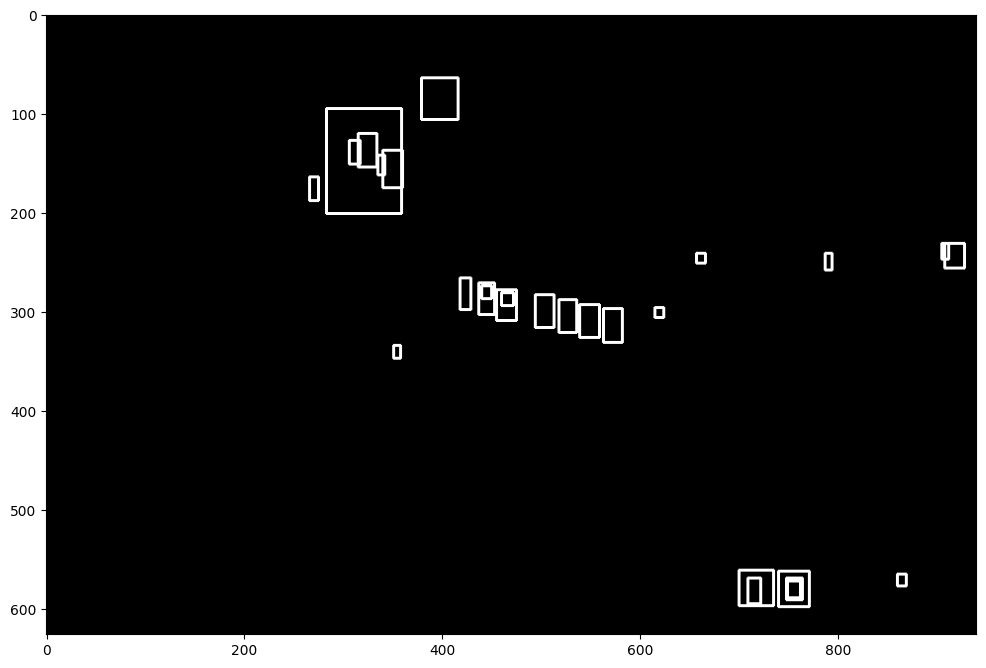

In [9]:
MIN_AREA = 80 # 너비는 최소 80픽셀은 되어야한다.
MIN_WIDTH, MIN_HEIGHT = 2, 8 # 2 픽셀이상의 너비, 8픽셀 이상의 높이를 지녀야함 
MIN_RATIO, MAX_RATIO = 0.25, 1.0 # 너비/높이의 비율. 폭이 1이면 높이 4이하 아래위로 길쭉. 장방형 까지(1/1)- 가로방향 직사각형은 안된다.

#지정한 비율, 너비, 높이, 넓이를 만족하는 외곽선만 남긴다

possible_contours = []

cnt = 0
for d in contours_dict:   #dictionary 한개씩 가져와서
    area = d['w'] * d['h'] # 넓이
    ratio = d['w'] / d['h'] # 비율(너비와 높이 비)
    
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO: # 비율이 최소 비율보단 커야하고 최대 비율보다는 작아야함(위로 길쭉하거나 못해도 정사각형이여야함)
        d['idx'] = cnt   # 새로운 idx key를 추가하고 
        cnt += 1
        possible_contours.append(d) # 만족하면 리스트에 저장
        
# 조건에 만족하는 사각형 영역 시각화
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours: # 조건을 만족하는 사각형 영역들 출력
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

## Select Candidates by Arrangement of Contours

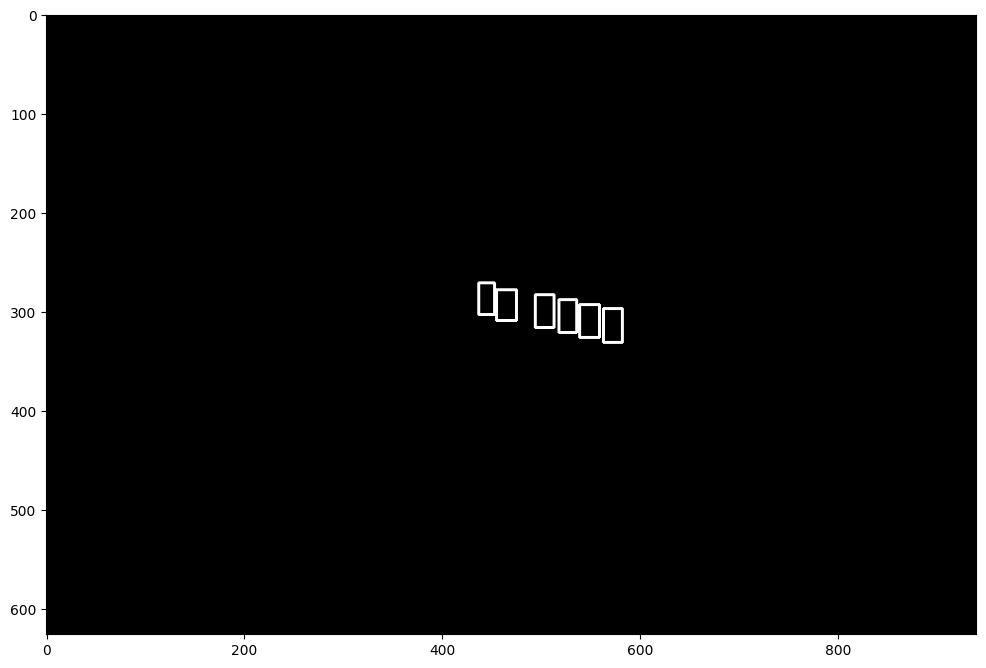

In [10]:
# 번호판상의 숫자들의 그룹을 추출

MAX_DIAG_MULTIPLYER = 5 # 번호판상의 숫자사각형들은 어느정도 붙어 있다. 사각형의 대각선 길이와 비교대상 사각형과의 떨어진 거리 비율이 5배 이내여야 한다.
MAX_ANGLE_DIFF = 12.0 # 중심을 이은 선을 빗변으로 하는 삼각형을 그렸을 때의 각도(세타) 값. 
                        #너무 높이 있거나 아래에 있으면 후보군이 될 수 없다. 
MAX_AREA_DIFF = 0.5 # 면적차이(서로 면적 차이가 거의 없어야 함)
MAX_WIDTH_DIFF = 0.8 # 너비차이
MAX_HEIGHT_DIFF = 0.2 # 높이차이
MIN_N_MATCHED = 3 # 후보군(만든 리스트의 원소 수)이 3보다 커야함

def find_chars(contour_list):  # possible_contours: 조건을 만족하는 사각형 영역들을 넘겨받아서...
    matched_result_idx = []
    
    for d1 in contour_list: # 리스트에서 하나의 사각형영역과 나머지 사각형 영역과 전부 비교하여 조건에 맞으면 그룹으로 간주
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']: # 같은 사각형 영역은 무시
                continue

            dx = abs(d1['cx'] - d2['cx']) # 중심 x좌표의 거리
            dy = abs(d1['cy'] - d2['cy']) # 중심 y좌표의 거리

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2) # 비교기준사각형의 대각선 길이(삼각형 빗변길이:피타고라스정리 Pythagorean theorem)

            # Linear Regression(선형회귀분석) - norm : [etc참고\Norm(L1,L2).pdf]
            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']])) # 원점 거리 구하기
            if dx == 0:
                angle_diff = 90 # dx가 0이면 높이만 다르고 같은 위치에 있다는 것이므로, 분모가 0이 되는것을 방지하기위해 고정값을 줌
            else:
                angle_diff = np.degrees(np.arctan(dy / dx)) 
                # angle_diff.pdf  참고
                # 세타값은 삼각함수에서 유도할 수 있다. tan(세타) = dy/dx이므로
                # 역함수를 취하면,
                # 세타 = arctan(dy/dx)
                # 결과가 라디안 이므로 np.degrees 함수로 라디안에서 도 로 바꿔준다.
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])
                
        matched_contours_idx.append(d1['idx']) # 판별이 끝나면 처음 기준사각형 또한 그룹에 포함시킴.
       
        # 후보군의 포함된 원소의 갯수가 4보다 작으면 번호판상의 숫자들의 그룹으로 볼수 없기 떄문에 제외시킴.
        # matched_contours_idx = [], 다시 초기화 시키고 다음의 사각형 영역을 기준으로 다시 탐색
        if len(matched_contours_idx) < MIN_N_MATCHED: 
            continue

        matched_result_idx.append(matched_contours_idx) # 최종후보군에 포함

        # 사각형 영역 4개 이상의 그룹을 찾으면 여기로 와서 탈락한 영역들에 대해서만 한번더 조사한다.....
        # 굳이 필요한가... 안해도 결과는 동일하다... 아니다... 최소한 이건 반드시 해야 한다..
        #  y, x의 증가방향 순으로 검색한다.... 예제 영상의 번호판들의 기울기가 만약 반대라면 
        #  아래의 방법을 동원해도 그룹을 찾지 못한다.  
        
        # 아래부터 원본 주석처리
        unmatched_contour_idx = [] 
        for d4 in contour_list: # 후보군에 속하지 못한것들 끼리도 비교해서 추가할 것을 추가함
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])
        # etc참고 : np.take.py 
        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        
        # 재귀 호출. 후보군에 속하지 못한 것들끼리 다시 비교.
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list: # 그중에서 새로운 후보군이 있다면 최종 후보군에 포함
            matched_result_idx.append(idx)
        # 여기까지 원본 주석처리
        
        break # 사각형 영역 4개 이상의  그룹을 찾으면 for를 빠져나간다.

    return matched_result_idx # 최종 후보군 반환
    

result_idx = find_chars(possible_contours) # 번호판 후보군 찾기.

matched_result = []
for idx_list in result_idx:  # 찾은 모든 그룹에 대해서 각각 돌면서 matched_result로 통합한다. list의 list
    matched_result.append(np.take(possible_contours, idx_list))

# 최종 리스트를 시각화함.
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)
plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

## Rotate Plate Images

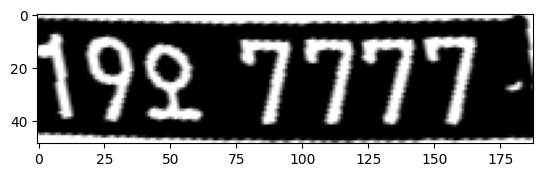

In [11]:
PLATE_WIDTH_PADDING = 1.3 # 너비값에 곱해줄 상수값
PLATE_HEIGHT_PADDING = 1.5 # 높이값에 곱해줄 상수값
MIN_PLATE_RATIO = 3 # 최소 번호판 비율 
MAX_PLATE_RATIO = 10 # 최대 번호판 비율

# 번호판 비율은 옆으로 길쭉한지 확인함.

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx']) # x축 기준으로 정렬함.(순서를 맞추기 위함)

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2 # 번호판 영역의 중심 x좌표 (후보군의 맨 앞 윤곽선의 x와 맨 뒤 윤곽선의 x의 평균)
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2 # 번호판 영역의 중심 y좌표 (위와 같은 방법으로 구함)
    
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING # 번호판 너비를 구함
    
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING) # 번호판 높이를 구함 (전체 숫자 영역들의 높이 평균 * 상수값)
    
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy'] # 회전 행렬을 구하기 위해 각도를 구하기위한 높이
    triangle_hypotenus = np.linalg.norm( # 각도를 구하기 위한 빗변의 길이
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus)) # 각도 세타는 빗변분의 높이값을 아크 코사인값을 써서 구함
    
    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0) # 회전행렬을 구함
    
    img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height)) # 어파인변환. 영상의 비율은 지키면서 회전을 수행함.
    plt.imshow(img_rotated, cmap='gray')
    img_cropped = cv2.getRectSubPix( # 회전된 이미지에서 번호판 영역만큼 잘라냄
        img_rotated, 
        patchSize=(int(plate_width), int(plate_height)), 
        center=(int(plate_cx), int(plate_cy))
    )
    
    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue
        #잘라낸 번호판의 비율을 상수와 비교함
        #비율이 맞지않으면 무시
    
    plate_imgs.append(img_cropped) # 부합하면 리스트에 추가
    plate_infos.append({ 
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })
    
    plt.subplot(len(matched_result), 1, i+1)
    plt.imshow(img_cropped, cmap='gray')

## MNIST 데이터 불러오기 및 정규화 
#### 인식기 구현 - 필기체 숫자인식 기반 전이학습 포함
#### 노트북컴퓨터에서, 저장한 학습데이터를 불러오는 load_model()에서 Error가 발생하여 할수 없이 인식기 포함함
#### 번호판인식(CNN).ipynb 참고 - load_model()에서 오류발생

In [12]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

# 픽셀 값을 0~1 사이로 정규화합니다.
train_images, test_images = train_images / 255.0, test_images / 255.0

## CNN 모델 생성

In [13]:
# CNN 모델을 생성한다.

# Convoultion 한 후 Output size 는 다음과 같이 계산된다.
# (W - F + 2P) / S + 1
# W : 원래 이미지 크기
# F : 커널의 크기
# P : 패딩의 크기 (패딩은 이미지 바깥에 임의의 값 영역을 추가로 주는 것을 의미. 보통 0으로 주는 Zero-Padding 방식을 사용)
# S : Stride의 크기 (커널의 이동 거리. 기본값은 1)

# MaxPooling 한 후 Output size 는 다음과 같이 계산된다.
# (W - M) / S + 1
# W : 원래 이미지의 크기
# M : Pooling 커널의 크기
# S : Stride의 크기 (Pooling 커널의 이동 거리. Convoultion과 다르게 Pooling의 기본 Stride값은 2 이다.)

i = Input(shape=(28, 28, 1)) # 첫번째 층. 입력레이어. 28*28*1의 이미지
x = layers.Conv2D(32, (3, 3), activation='relu')(i) # 3 * 3 커널 32개를 지니는 Convolution 레이어

                                       # 출력 : (28 - 3 + 0) / 1 + 1 = 26 이고 32개의 커널이 존재하므로 최종적으로 26 * 26 * 32 의 output size를 가진다.

x = layers.MaxPooling2D((2, 2))(x) # 각 26 * 26 에서 2 * 2의 크기를 지니는 커널을 이동시켜가며 가장 큰 값을 뽑아내는 Max Pooling 레이어

                                       # 출력 : (26 - 2) / 2 + 1 = 13 이고 들어온 input이 32개 이므로 최종적으로 13 * 13 * 32 의 output size를 가진다.

x = layers.Conv2D(64, (3, 3), activation='relu')(x) # 64개의 3 * 3 커널을 사용하는 Convolution 레이어

# 출력 : (13 - 3 + 0) / 1 + 1 =  11, 결과 : 11 * 11 * 64

x = layers.MaxPooling2D((2, 2))(x)

# 출력 : (11 - 2) / 2 + 1 = 5, 결과 : 5 * 5 * 64

x = layers.Conv2D(64, (3, 3), activation='relu')(x)

# 출력 : (5 - 3 + 0) / 1 + 1 = 3, 결과 : 3 * 3 * 64

x = layers.Flatten()(x) # 완전연결신경망으로 데이터를 전달하기위해서 이미지를 1차원 벡터로 펼쳐주는 층. 9 * 9 * 64 = 5184의 1차원 벡터를 생성함.

x2 = layers.Dense(64, activation='relu')(x) # 64개의 노드를 지니는 일반 층
x3 = layers.Dense(64, activation='relu')(x2) # 64개의 노드를 지니는 일반 층
y = layers.Dense(10, activation='softmax')(x3) # 10개의 노드를 지니는 일반층(class 분류 결과를 보여주기위해 softmax 활성화 함수 사용)
model = Model(inputs=i,outputs=y) # 두개의 모델 연결
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928 

In [14]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 22s 11ms/step - loss: 0.1649 - accuracy: 0.9485
Epoch 2/5
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0508 - accuracy: 0.9842
Epoch 3/5
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0383 - accuracy: 0.9885
Epoch 4/5
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0290 - accuracy: 0.9910
Epoch 5/5
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0240 - accuracy: 0.9928


In [15]:
image_list = os.listdir('./imgs') # imgs라는 폴더 안의 모든 파일명을 가져옵니다.

roi_list = [] # 실제 프로그램 내에서 사용될 리스트.
labels = [] # 실제 프로그램 내에서 사용될 target값.

for img in image_list:
  roi = cv2.imread('./imgs/'+img) # imgs 폴더에 있는 이미지 하나씩 불러옴
  roi_gray = cv2.cvtColor(roi,cv2.COLOR_BGR2GRAY) # 흑백으로 변환
  thr = cv2.adaptiveThreshold(roi_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2) # 이진화 시킴. 방식은 apdative threshold
  thr = cv2.resize(thr, dsize=(28, 28), interpolation=cv2.INTER_AREA) # 28 * 28 으로 이미지 크기 변환
  thr = thr / 255.0 # 0~1 사이의 값으로 정규화
  thr = thr.reshape((28,28,1)) # 딥러닝 모듈에 집어넣기 위해서 2차원 흑백이미지를 3차원으로 변환

  roi_list.append(thr) # 리스트에 추가
  labels.append(int(img[0])) # 파일명의 맨 앞글자(숫자)로 라벨을 지정하고 리스트에 추가

train_images2 = np.array(roi_list) # 학습될 이미지 numpy array로 변환
train_labels2 = np.array(labels) # 학습될 라벨 numpy array로 변환

In [16]:
x.trainable = False # Convolution Layer들은 학습시키지 않는다.

In [17]:
model.fit(train_images2, train_labels2, epochs=5)

Epoch 1/5
20/20 [==============================] - 1s 11ms/step - loss: 0.3431 - accuracy: 0.9117
Epoch 2/5
20/20 [==============================] - 0s 11ms/step - loss: 0.0506 - accuracy: 0.9905
Epoch 3/5
20/20 [==============================] - 0s 12ms/step - loss: 0.0197 - accuracy: 0.9984
Epoch 4/5
20/20 [==============================] - 0s 15ms/step - loss: 0.0077 - accuracy: 0.9984
Epoch 5/5
20/20 [==============================] - 0s 13ms/step - loss: 0.0137 - accuracy: 0.9968


## Another Thresholding to Find Chars

1/1 [==============================] - 0s 52ms/step
0  9  7  7  7  7  


C:\Users\Yimoogi\AppData\Local\Temp\ipykernel_10316\3437173855.py:69: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(len(plate_imgs)+1, 1, i+1)
C:\Users\Yimoogi\AppData\Local\Temp\ipykernel_10316\3437173855.py:73: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  p = plt.subplot(2,len(roi_list)+1,j+1)


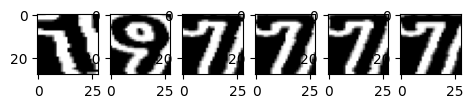

In [18]:
plate_chars = []

for i, plate_img in enumerate(plate_imgs):
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
    #plt.imshow(plate_img, cmap='gray')
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    plt.imshow(plate_img, cmap='gray')
    
    # find contours again (same as above)
    contours, _ = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    
    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

    for contour in contours: # 번호판 내에서 다시 contour를 찾고 bounding rect를 구하고 조건에 만족하는지 한번 더 확인
        x, y, w, h = cv2.boundingRect(contour)
        
        area = w * h
        ratio = w / h

        if area > MIN_AREA \
        and w > MIN_WIDTH and h > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h
                
    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]
    
    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0) # 글자 검출전에 전처리
    #plt.imshow(img_result, cmap='gray')
    
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU) # 오추알고리즘을 사용해 이진화
    #plt.imshow(img_result, cmap='gray')

    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
    #인식이 잘되게끔 10만큼의 패딩을 준다


    #model = load_model('my_cnn_model_new.h5') # HD5 파일로 부터 모델과 학습된 weights를 가져온다.

    chars = cropchar.crop_characters(img_result) # 번호판에서 숫자를 추출함
    if len(chars) == 0:
        print(i+1+' 찾아낸것 없음.')
        continue

    roi_list = [] # 각 숫자를 전처리 한 후 저장할 리스트
    for char in chars:
      thr = cv2.adaptiveThreshold(char, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2) # 이진화 시킴. 방식은 apdative threshold
      #_, thr = cv2.threshold(char, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
      thr = cv2.resize(thr, dsize=(28, 28), interpolation=cv2.INTER_AREA) # 크기를 28,28으로 바꿈
      thr = thr.reshape((28,28,1)) # tensorflow는 이미지 차원이 항상 3차원이여야 함. 따라서 차원을 하나 늘려줌.
      thr = thr / 255.0 # 모든 픽셀값을 0~1 사이 값으로 정규화 시킴

      roi_list.append(thr) # 리스트에 저장

    roi_list = np.array(roi_list) # 파이썬 리스트를 numpy array로 변환.
    predictions = model.predict(roi_list) # 각 숫자별로 모델에게 예측을 수행하고 결과를 받아옴.

    for predict in predictions:
      print(np.argmax(predict),end='  ') # 예측값 중에 가장 큰 class 값을 출력.
    print('')

    plt.subplot(len(plate_imgs)+1, 1, i+1)
    plt.imshow(img_result, cmap='gray')
    
    for j, img in enumerate(roi_list):
        p = plt.subplot(2,len(roi_list)+1,j+1)
        p.imshow(img,cmap='gray')

    